In [2]:
import pytesseract
import numpy as np
import re
import csv
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.styles import ParagraphStyle
from reportlab.platypus import Paragraph

# Image processing 

In [15]:
# Function to enhance image quality
def enhance_image(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding to separate background from text
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    # Invert the thresholded image
    thresholded = cv2.bitwise_not(thresholded)
    
    return thresholded

    # Sharpen the image
    kernel = np.array([
        [-1, -1, -1],
        [-1, 12, -1],  # Increase center weight
        [-1, -1, -1]
    ])
    sharpened = cv2.filter2D(thresholded, -1, kernel)
    
    return sharpened

# Load the image
image_path = "Fine6.jpeg"
image = cv2.imread(image_path)

# Enhance the image quality
enhanced_image = enhance_image(image)




In [16]:
import torch
from torch import cuda
from spandrel import ImageModelDescriptor, ModelLoader
from PIL import Image
import torchvision.transforms as transforms
from pathlib import Path
import gc  # Import garbage collector
import cv2
import numpy as np

# Constants for normalization
NORMALIZE_MEAN = [0.5, 0.5, 0.5]
NORMALIZE_STD = [0.5, 0.5, 0.5]
PATCH_SIZE = (256, 256)  # Expected size of each patch for processing

# Path to stored model file
MODEL_FILENAME = "8x_NMKD-Typescale_175k.pth"
current_dir = Path.cwd()
model_path = current_dir / MODEL_FILENAME

# Function to convert OpenCV image to a PyTorch tensor
def cv2_image_to_tensor(image_cv2):
    # OpenCV images are numpy arrays, convert to PIL for consistent handling
    image_pil = Image.fromarray(cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB))
    
    # Transformation pipeline for image preprocessing before input to the model
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD)
    ])
    
    # Apply transformations to obtain tensor and add batch dimension
    image_tensor = transform(image_pil).unsqueeze(0)
    
    return image_tensor

# Function to load the pretrained image upscaling model
def load_model(model_path: Path) -> ImageModelDescriptor:
    # Load the model from file
    model = ModelLoader().load_from_file(str(model_path))
    assert isinstance(model, ImageModelDescriptor), "The loaded model must be an ImageModelDescriptor."
    
    # If CUDA is available, move model to GPU and convert to half precision for faster execution
    if cuda.is_available():
        model = model.cuda()
        model = model.half()
    
    model.eval()  # Set the model to evaluation mode
    return model

# Function to upscale the image using the model
def upscale_image(model, input_image: torch.Tensor) -> torch.Tensor:
    # Get image height and width
    H, W = input_image.shape[2], input_image.shape[3]
    
    # Estimate the scale factor based on your model's specifications
    scale_factor = 8  # Replace with model scale factor if different
    
    # Prepare an empty tensor for the output image, with correct dimensions after upscaling
    full_output = torch.zeros(1, 3, H*scale_factor, W*scale_factor)  # Assumes model preserves batch size and channels (3 = RGB)
    full_output = full_output.half() if cuda.is_available() else full_output
    
    # Process the image in patches to manage GPU memory usage
    for i in range(0, H, PATCH_SIZE[0]):
        for j in range(0, W, PATCH_SIZE[1]):
            input_patch = input_image[:, :, i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            
            # Calculate the position where this patch will be placed in the full_output tensor
            ih, iw = i*scale_factor, j*scale_factor
            
            # Process patch
            if cuda.is_available():  # Use CUDA if available
                input_patch = input_patch.cuda().half()
            with torch.no_grad():  # Disable gradients for inference to reduce memory usage
                output_patch = model(input_patch)
            
            # Place the output patch into the full_output tensor
            full_output[:, :, ih:ih+output_patch.shape[2], iw:iw+output_patch.shape[3]] = output_patch.cpu()
            
            if cuda.is_available():
                torch.cuda.empty_cache()  # Clear CUDA cache after processing each patch
    
    full_output = full_output.float()  # Convert tensor back to float from half precision
    return full_output.squeeze(0)  # Remove batch dimension before returning the image tensor

# Function to process a numpy image array, upscale it and return as a tensor
def process_numpy_image(image_np):
    gc.collect()  # Run garbage collection to free memory
    if cuda.is_available():
        cuda.empty_cache()  # Empty CUDA cache

    # Load the model
    model = load_model(model_path)
    # Convert numpy image to tensor
    input_tensor = cv2_image_to_tensor(image_np)
    # Perform the upscaling
    output_image_tensor = upscale_image(model, input_tensor)
    
    return output_image_tensor  # Return the tensor representing the upscaled image

# Assuming enhanced_image is provided as a numpy array from an image enhancement process.
# Call the function with the array to upscale it.
# enhanced_image = <your enhanced numpy array from previous steps
# Assuming enhanced_image is provided as a numpy array from an image enhancement process.
# Substitute "<your enhanced numpy image>" with the actual variable that contains your enhanced image.

enhanced_image = enhanced_image # Replace with your actual enhanced image

# Now, using the enhanced_image numpy array, invoke the upscaling process
# First, ensure that you have the enhanced_image array from your enhancement process:
# enhanced_image should be the output from your image enhancement code cell

# Process the enhanced image to get upscaled image tensor
upscaled_tensor = process_numpy_image(enhanced_image)

# If you want to convert the tensor back to an OpenCV image format:
enhanced_upscaled_image = upscaled_tensor.cpu().detach().numpy()  # Convert tensor to numpy array
enhanced_upscaled_image = np.transpose(enhanced_upscaled_image, (1, 2, 0))  # Rearrange the axes from CHW to HWC
enhanced_upscaled_image = cv2.cvtColor(enhanced_upscaled_image, cv2.COLOR_RGB2BGR)  # Convert from RGB to BGR

# At this point, `enhanced_upscaled_image` is a numpy array that can be handled by OpenCV
# You might choose to save the result, display it, or perform further processing.

# Optional: Save the result with OpenCV
cv2.imwrite('enhanced_upscaled_image.jpg', enhanced_upscaled_image * 255)  # Be sure to scale back up to 0-255 range for OpenCV

# Optional: Display the image inline in the Jupyter notebook with matplotlib
import matplotlib.pyplot as plt

# Convert the image from BGR to RGB for displaying correctly
plt_image = cv2.cvtColor(enhanced_upscaled_image, cv2.COLOR_BGR2RGB) / 255.0  # Scale to 0-1 range for matplotli


##### Save image 

In [23]:
# Define a filename for the image to be saved
output_filename = 'enhanced_upscaled_image.png'
# Ensure the enhanced_upscaled_image numpy array is correctly formatted
# with pixel values in the range [0, 1] before saving.
# If the values are within [0, 255], remove the multiplication by 255.
enhanced_upscaled_image_to_save = (enhanced_upscaled_image * 255).astype(np.uint8) if enhanced_upscaled_image.max() <= 1.0 else enhanced_upscaled_image
# Save the image using OpenCV
cv2.imwrite(str(current_dir / output_filename), enhanced_upscaled_image_to_save)
print(f"Image saved as {output_filename} in the current directory")

Image saved as enhanced_upscaled_image.png in the current directory


##### Denoiser 

In [41]:
import numpy as np

def denoise_image(enhanced_image):
    denoised_image = cv2.fastNlMeansDenoising(image, None, h=30, templateWindowSize=7, searchWindowSize=21)
    return denoised_image

denoised_image = denoise_image(enhanced_image)


# Check Difference 

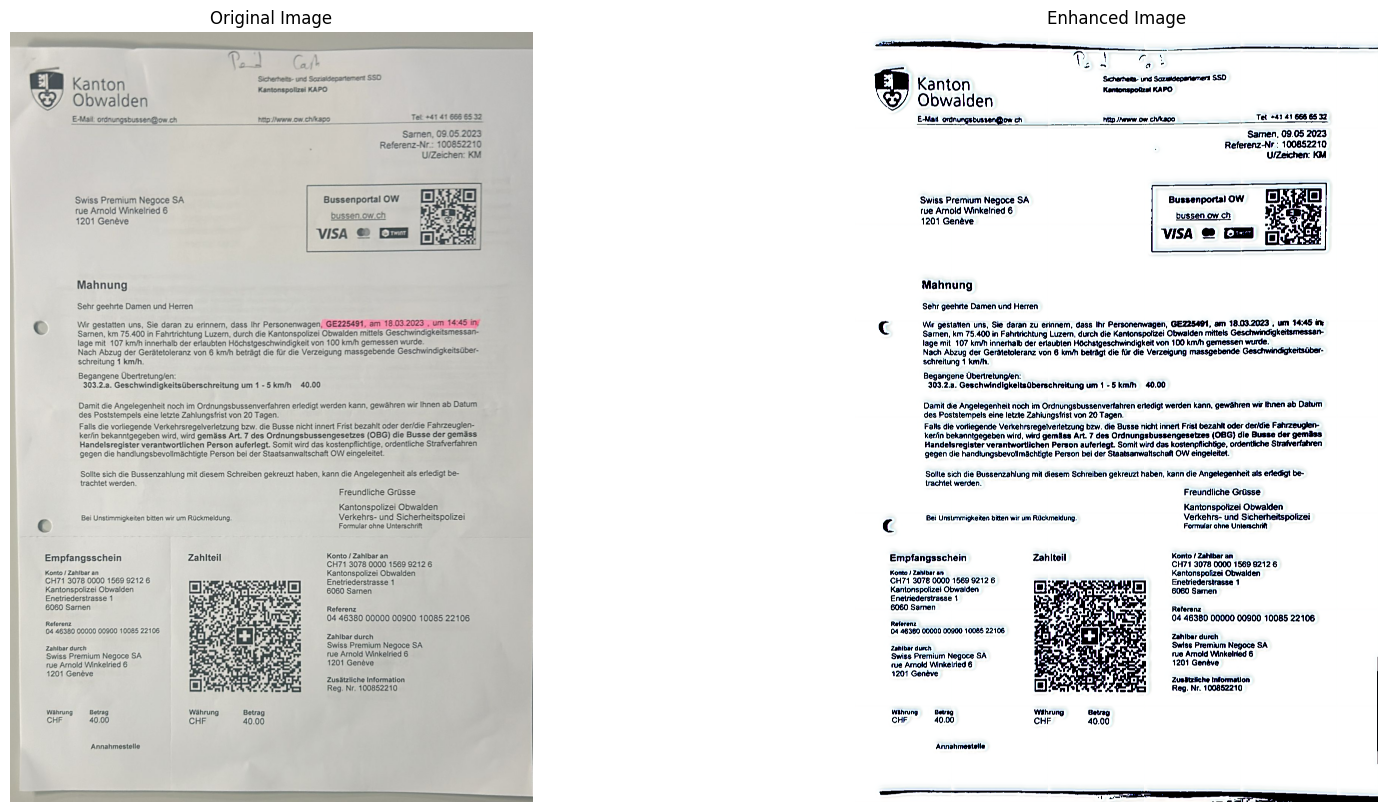

In [17]:
# Plot the original and enhanced images
plt.figure(figsize=(20, 10))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Plot the enhanced image
plt.subplot(1, 2, 2)
plt.imshow(enhanced_upscaled_image, cmap='gray')
plt.title('Enhanced Image')
plt.axis('off')

plt.show()

# Extract Text 

#### Extracting relevant text only 

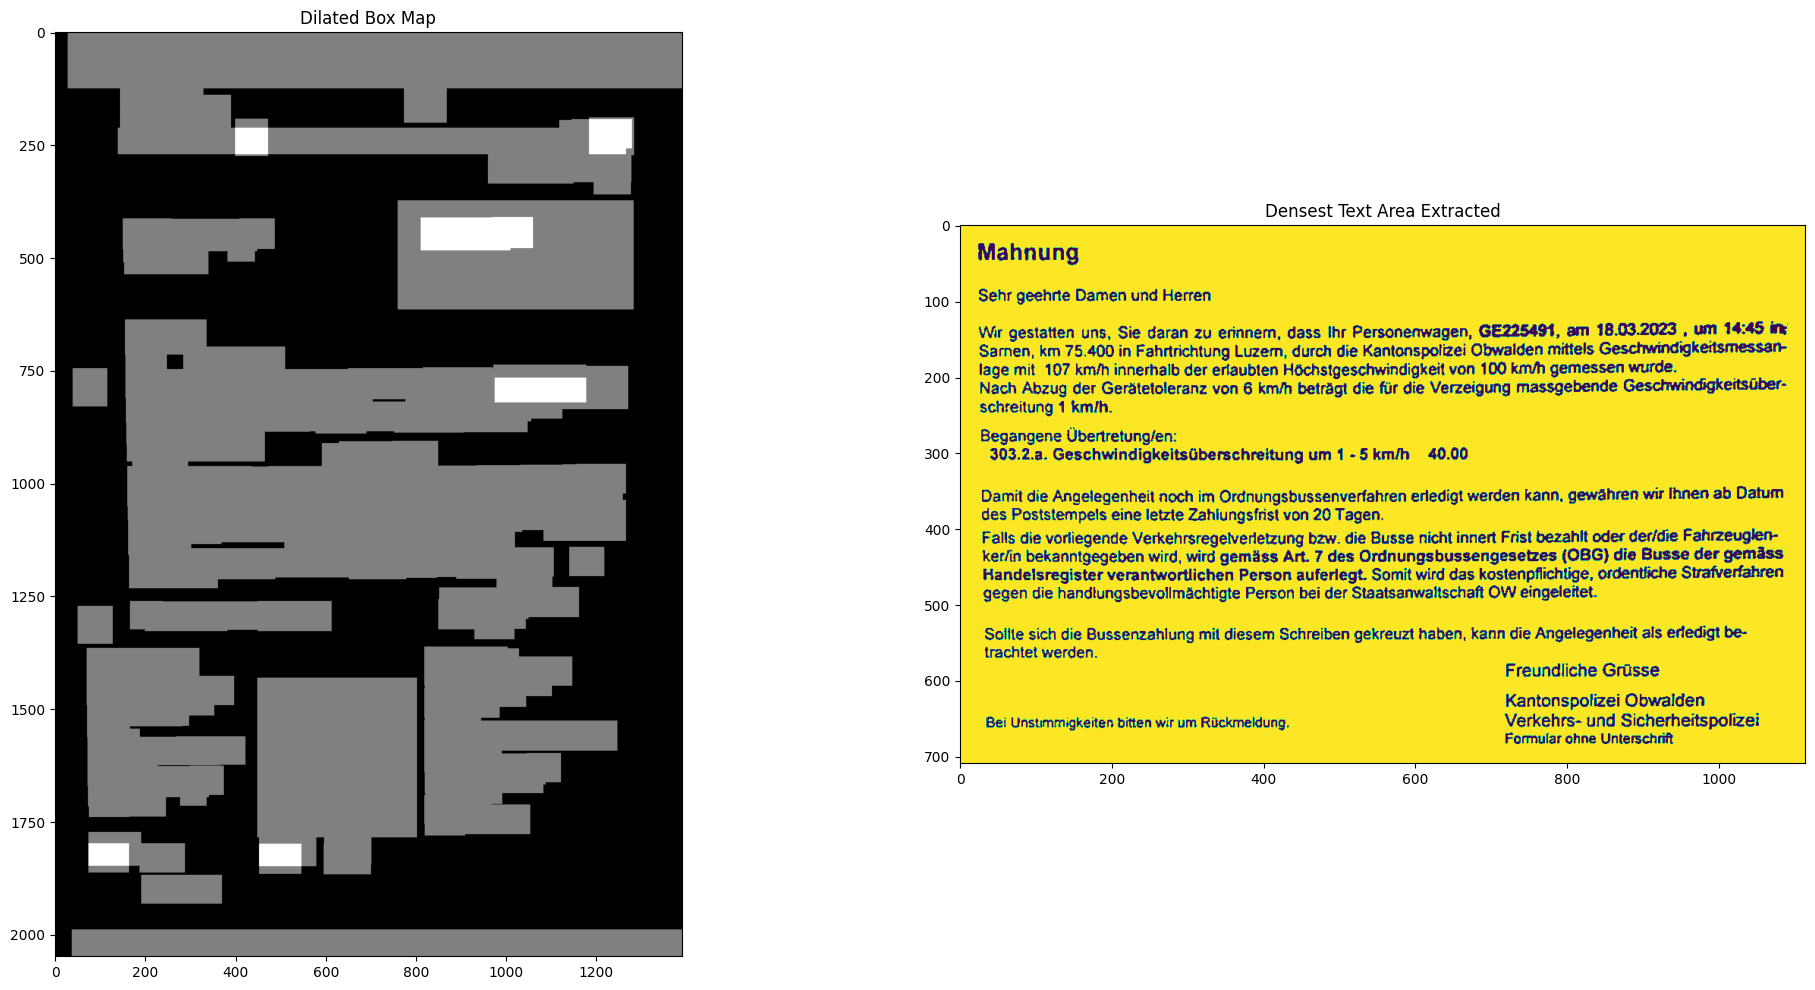

Densest text extracted:
Mahnung

Sehr geehrte Damen und Herren

Wir gestatten uns, Sie daran zu erinnern, dass Ihr Personemwagen, GE225491, am 18.03.2023, um 1445 in
Samnen, km 75.400 in Fahrtrichtung Luzem, durch die Kantonspolizei Obwalden mittels Geschwindigkeitsmessan-
lage mit 107 km/h innerhalb der erlaubten Hôchstgeschwindigkeit von 100 km/h gemessen wurde.

Nach Abzug der Gerätetoleranz von 6 km/h beträgt die für die Verzeigung massgebende Geschwindigkeitsüber-
schreitung 1 km/h.

Begangene Übertretung/en:
303.2.2. Geschwindigkeitsüberschreitung um 1-5km/h 40.00

Damit die Angelegenheit noch im Ordnungsbussenverfahren erledigt werden kann, gewähren wir Ihnen ab Datum
des Poststempels eine letzte Zahiungsfrist von 20 Tagen.

Falls die voriiegende Verkehrsregelveretzung bzw. die Busse nicht innert Frist bezahlt oder der/die Fahrzeuglen-
ker/in bekanntgegeben wird, wird gemäss Art. 7 des Ordnungsbussengesetzes (OBG) die Busse der gemäss
Handelsregister verantwortlichen Person aufe

In [24]:

def find_densest_text_area(image, config):
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    
    image_np = np.array(image)
    data = pytesseract.image_to_data(image, config=config, output_type=pytesseract.Output.DICT)
    box_map = np.zeros(image_np.shape[:2], dtype=np.uint8)

    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 60:
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            box_map[y:y+h, x:x+w] += 1

    kernel_size = 50 # Increase kernel size for more aggressive merging
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    box_map_dilated = cv2.dilate(box_map, kernel, iterations=1)

    threshold_value = np.max(box_map_dilated) * 0.4  # Lower the threshold slightly
    _, box_map_thresholded = cv2.threshold(box_map_dilated, threshold_value, 255, cv2.THRESH_BINARY)

    # Set up the figure with two subplots
    plt.figure(figsize=(24, 12))  # Set the figure size to be wide enough for two subplots
    
    # Subplot for the dilated box map
    plt.subplot(1, 2, 1)  # (1 row, 2 columns, 1st subplot)
    plt.imshow(box_map_dilated, cmap='gray')
    plt.title("Dilated Box Map")

    contours, _ = cv2.findContours(box_map_thresholded.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print("No dense text areas detected.")
        plt.show()
        return None

    img_center_x, img_center_y = image.width // 2, image.height // 2
    max_score = 0
    best_rect = None
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        center_x, center_y = x + w // 2, y + h // 2
        distance = np.sqrt((center_x - img_center_x)**2 + (center_y - img_center_y)**2)
        score = area / (distance + 1)  # Increased weight to area

        if score > max_score:
            max_score = score
            best_rect = (x, y, w, h)

    if not best_rect:
        print("No suitable area found.")
        plt.show()
        return None

    x, y, w, h = best_rect
    densest_area = image.crop((x, y, x + w, y + h))

    # Subplot for the selected densest area
    plt.subplot(1, 2, 2)  # (1 row, 2 columns, 2nd subplot)
    plt.imshow(densest_area)
    plt.title('Densest Text Area Extracted')
    plt.show()

    densest_text = pytesseract.image_to_string(densest_area, config=config)
    return densest_text

# Convert upscaled numpy array back to PIL Image
enhanced_upscaled_image_pil = Image.fromarray(enhanced_upscaled_image)

# Tesseract configuration
config = '--psm 4 -l fra'

# Now, find the densest text area in the upscaled image
densest_text = find_densest_text_area(enhanced_upscaled_image_pil, config)
if densest_text:
    print("Densest text extracted:")
    print(densest_text)
else:
    print("No text was extracted.")


# Translate from any language to English 

In [19]:
from googletrans import Translator

def translate_to_english(densest_text):
    translator = Translator()

    # Detect language
    detected_lang = translator.detect(densest_text).lang

    # Translate to English if necessary
    if detected_lang != 'en':
        translated_text = translator.translate(densest_text, dest='en').text
    else:
        translated_text = densest_text

    return translated_text

translated_text = translate_to_english(densest_text)
print("Translated Text:", translated_text)

Translated Text: warning

Ladies and Gentlemen

We allow ourselves to remind you that your personnel car, GE225491, on March 18, 2023, around 1445 in
Samnen, km 75,400 in the direction of Luzem, through the cantonal police Obwalden by means of speed measurement
Location at 107 km/h within the permitted highest speed of 100 km/h.

After deducting the device tolerance of 6 km/h
Cleaning 1 km/h.

Committed violation/en:
303.2.2.Speed crossing around 1-5km/h 40.00

From the date
of the post stamp one last egal period of 20 days.

If the pre-bound traffic regulations or the buses are not paid within time or the vehicle
ker/in is announced, the buses of the
Commercial register responsible.Thus, the expedient, ordinary criminal proceedings
Against the handicapped person at the public prosecutor's office OW.

Solite has crossed the bus payment with this letter, the matter can be
be tried.
Friends greetings

Cantonal police Obwalden

In the event of discrepancies, we ask for feedback.Transport 

# Extreact Features (NLP)

In [30]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline

# Load a more powerful pre-trained model and tokenizer
model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# Set up the question-answering pipeline
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

# Assuming 'translated_text' is the context obtained from previous text processing steps
questions = [
    "What is the plate number of the car?",
    "When did the infraction happen?",
    "What was the infraction?"
]

# Get answers from the model using the translated text as context
answers = {question: qa_pipeline({"question": question, "context": translated_text})['answer'] for question in questions}

# Print the answers
for question, answer in answers.items():
    print(f"Question: {question}\nAnswer: {answer}\n")


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Question: What is the plate number of the car?
Answer: GE225491

Question: When did the infraction happen?
Answer: March 18, 2023

Question: What was the infraction?
Answer: Speed crossing



# Fine Estimation

In [30]:
from FineEstimator import estimate_fine  
# Convert extracted speed values to integers
vitesse_autorisee = int(extracted_info.get('Vitesse autorisée', 0))
vitesse_mesuree = int(extracted_info.get('Vitesse mesurée', 0))

# Estimate fine based on extracted information
if vitesse_autorisee and vitesse_mesuree:
    # Calculate actual speeding
    speeding = vitesse_mesuree - vitesse_autorisee
    print("Actual Speeding:", speeding)
    
    # Estimate fine based on actual speeding
    fine_estimate = estimate_fine(vitesse_autorisee, vitesse_mesuree)
    print("Fine Estimate:", fine_estimate)
else:
    print("Unable to estimate fine.")


Actual Speeding: 26
Fine Estimate: Potential criminal offense
